In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Update these paths according to your system
BASE_DIR = r"C:/Users/suhan/Downloads/archiveFoods/food-101/food-101"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
META_DIR = os.path.join(BASE_DIR, "meta")

# Load train.txt
with open(os.path.join(META_DIR, "train.txt"), "r") as f:
    train_lines = f.read().splitlines()

# Load test.txt
with open(os.path.join(META_DIR, "test.txt"), "r") as f:
    test_lines = f.read().splitlines()

# Generate full image paths and labels
train_image_paths = [os.path.join(IMAGE_DIR, line + ".jpg") for line in train_lines]
train_labels = [line.split("/")[0] for line in train_lines]

test_image_paths = [os.path.join(IMAGE_DIR, line + ".jpg") for line in test_lines]
test_labels = [line.split("/")[0] for line in test_lines]

# Example check
print(f"Total training images: {len(train_image_paths)}")
print(f"Total testing images: {len(test_image_paths)}")
print(f"Example image path: {train_image_paths[0]}")
print(f"Example label: {train_labels[0]}")


Total training images: 75750
Total testing images: 25250
Example image path: C:/Users/suhan/Downloads/archiveFoods/food-101/food-101\images\apple_pie/1005649.jpg
Example label: apple_pie


In [2]:
SAMPLE_size = 5000
IMG_size = 224

# Select subset
sample_train_paths = train_image_paths[:SAMPLE_size]
sample_train_labels = train_labels[:SAMPLE_size]

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sample_train_labels)

# Save label classes for future use
np.save("label_classes.npy", le.classes_)

# Preprocess images
X = []
for img_path in tqdm(sample_train_paths, desc="Loading & Preprocessing Images"):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (IMG_size, IMG_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # Normalize
        X.append(img)

X = np.array(X)
y = np.array(y_encoded)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Label classes:", list(le.classes_)[:10])  # First 10 food categories

#with open("food_labels.txt", "w") as f:
#    for label in le.classes_:
 #       f.write(label + "\n")


Loading & Preprocessing Images: 100%|█████████████████████████████████████████████| 5000/5000 [00:32<00:00, 153.84it/s]


X shape: (5000, 224, 224, 3)
y shape: (5000,)
Label classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets']


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# One-hot encode labels (e.g., 0 → [1,0,0,...])
num_classes = len(le.classes_)
y_cat = to_categorical(y, num_classes)

# Load pre-trained base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional layers

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# Split data into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 32159s 259s/step - accuracy: 0.2588 - loss: 1.9979 - val_accuracy: 0.6410 - val_loss: 1.0978
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.5508 - loss: 1.1996 - val_accuracy: 0.7160 - val_loss: 0.8444
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 430ms/step - accuracy: 0.6530 - loss: 0.9487 - val_accuracy: 0.7450 - val_loss: 0.7444
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 434ms/step - accuracy: 0.7092 - loss: 0.8036 - val_accuracy: 0.7530 - val_loss: 0.7030
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 428ms/step - accuracy: 0.7169 - loss: 0.7873 - val_accuracy: 0.7590 - val_loss: 0.6690
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 403ms/step - accuracy: 0.7461 - loss: 0.6995 - val_accuracy: 0.7680 - val_loss: 0.6483
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 409ms/step - accuracy: 0.7616 - loss: 0.6758 - val_accuracy: 0.7730 - val_loss: 0.6235
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 417ms/step - accuracy: 0.7608 - loss:

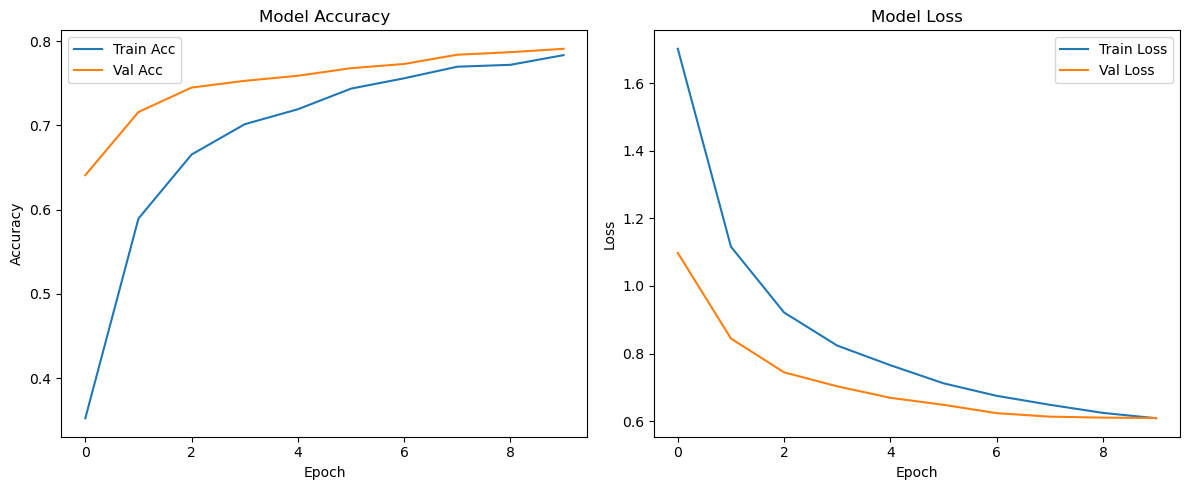

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


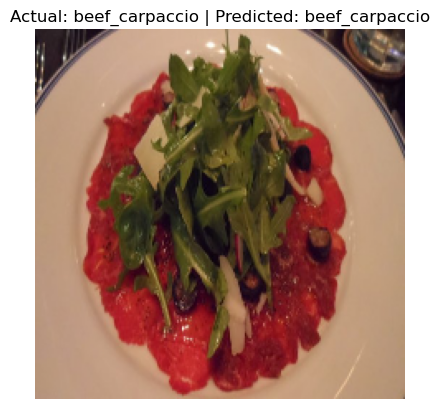

Predicted Food: beef_carpaccio
Estimated Calories: 150–200 kcal


In [18]:
# Pick a random test image
import random

idx = random.randint(0, len(X_val) - 1)
img = X_val[idx]
true_label = le.inverse_transform([np.argmax(y_val[idx])])[0]

# Predict
pred = model.predict(np.expand_dims(img, axis=0))
pred_label = le.inverse_transform([np.argmax(pred)])[0]

# Show result
plt.imshow(img)
plt.title(f"Actual: {true_label} | Predicted: {pred_label}")
plt.axis('off')
plt.show()

calorie_map = {
    'apple_pie': '300–350',
    'baby_back_ribs': '400–500',
    'baklava': '250–350',
    'beef_carpaccio': '150–200',
    'beef_tartare': '180–250',
    'beet_salad': '120–200',
    'beignets': '200–300',
}


# Get calorie estimate
estimated_cal = calorie_map.get(pred_label, "Unknown")

print(f"Predicted Food: {pred_label}")
print(f"Estimated Calories: {estimated_cal} kcal")

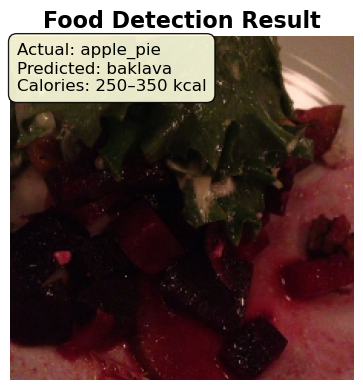


Prediction Summary
────────────────────────────
Actual Food:     apple_pie
Predicted Food:  baklava
Estimated Cal:   250–350 kcal
────────────────────────────



In [14]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Sample labels for demonstration
true_label = 'apple_pie'
pred_label = 'baklava'

# Calorie map with approximate ranges or values
calorie_map = {
    'apple_pie': '300–350',
    'baby_back_ribs': '400–500',
    'baklava': '250–350',
    'beef_carpaccio': '150–200',
    'beef_tartare': '180–250',
    'beet_salad': '120–200',
    'beignets': '200–300',
}

# Get estimated calories from the predicted label
estimated_cal = calorie_map.get(pred_label, 'N/A')

# Plot image with styled prediction and calorie info
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img)
ax.axis('off')

# Create a nice box for displaying info
box_text = f"Actual: {true_label}\nPredicted: {pred_label}\nCalories: {estimated_cal} kcal"

# Add a fancy info box
props = dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9)
ax.text(0.02, 0.98, box_text, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=props)

plt.title("Food Detection Result", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Print prediction summary
print("\nPrediction Summary")
print("────────────────────────────")
print(f"Actual Food:     {true_label}")
print(f"Predicted Food:  {pred_label}")
print(f"Estimated Cal:   {estimated_cal} kcal")
print("────────────────────────────\n")
